In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from structured import *
%matplotlib inline

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [54]:
set_plot_sizes(7,50,20)

In [4]:
train_df = pd.read_csv("dataset/train.csv", low_memory=False)
test_df = pd.read_csv("dataset/test.csv", low_memory=False)

In [3]:
#train_df.set_index('UCIC_ID', inplace=True)

In [4]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:,-1].values
test_ucic_id = test_df['UCIC_ID']

In [5]:
train_df.shape, test_df.shape

((300000, 376), (200000, 376))

In [26]:
X.shape, y.shape

((300000, 371), (300000,))

In [22]:
one = np.round(len(y[y == 1])*100/float(len(y)), 2)
zero = np.round(len(y[y == 0])*100/float(len(y)), 2)
print("Classes with 1: {}%\nClasses with 0: {}%".format(one, zero))

Classes with 1: 17.23%
Classes with 0: 82.77%


## Handling NaN

### 1. Remove columns where all values are NaN

In [5]:
train_df.dropna(axis=1, how='all', inplace=True)
train_df.dropna(axis=0, how='all', inplace=True)
#features.drop('city', axis=1, inplace=True)
#features.drop('zip', axis=1, inplace=True)

In [25]:
X.shape

(300000, 371)

### 2. Remove all such features that have 70% or more of the data as NaN

In [6]:
frac = train_df.shape[0] * 0.7
train_df.dropna(thresh=frac, axis=1, inplace=True)
train_df.shape

(300000, 216)

In [7]:
null_columns = train_df.columns[train_df.isnull().any()]
train_df[null_columns].isnull().sum()

OCCUP_ALL_NEW               96
city                      5701
dependents               26382
zip                       1050
FINAL_WORTH_prev1          186
ENGAGEMENT_TAG_prev1       186
Recency_of_CR_TXN        33194
Recency_of_DR_TXN        23252
Recency_of_BRANCH_TXN    18368
Recency_of_Activity        477
dtype: int64

### 3. Impute NAN values
- numerical: mean, median, mode
- categorical: max occurance obtained from value counts

In [12]:
train_cats(train_df)
X, y, _ = proc_df(train_df, 'Responders')

In [14]:
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

Series([], dtype: float64)

In [39]:
all_columns = train.columns.tolist()
new_columns = features.columns.tolist()
len(all_columns), len(new_columns)

(376, 213)

In [16]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(X)-n_valid
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [18]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((288000, 221), (12000, 221), (288000,), (12000,))

In [21]:
set_rf_samples(50000)

In [20]:
??RandomForestClassifier

In [27]:
def print_score(m):
    res = [accuracy_score(m.predict(X_train), y_train), accuracy_score(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [26]:
m = RandomForestClassifier(min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [28]:
print_score(m)

[0.8943402777777778, 0.86458333333333337, 0.87080208333333331]


In [29]:
fi = rf_feat_importance(m, X); fi[:10]

,cols,imp
36,EOP_prev1,0.165645
210,CR_AMB_Drop_Build_1,0.103475
37,CR_AMB_Prev1,0.032480
11,D_prev1,0.023993
15,BRANCH_D_prev1,0.021044
35,BAL_prev1,0.020222
211,CR_AMB_Drop_Build_2,0.018373
202,I_AQB_PrevQ1,0.017327
3,vintage,0.013729
212,CR_AMB_Drop_Build_3,0.013182


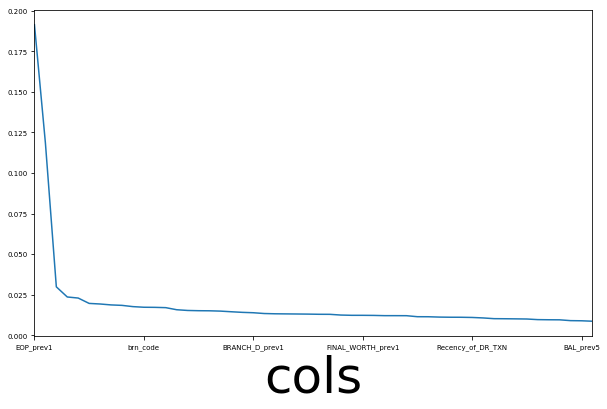

In [55]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [31]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

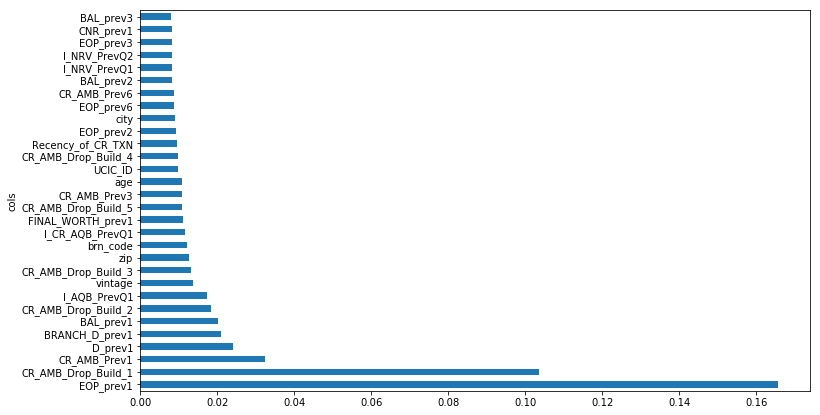

In [32]:
plot_fi(fi[:30]);

In [33]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

52

In [34]:
df_keep = X[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [35]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.90013194444444444, 0.87350000000000005, 0.87812847222222223]


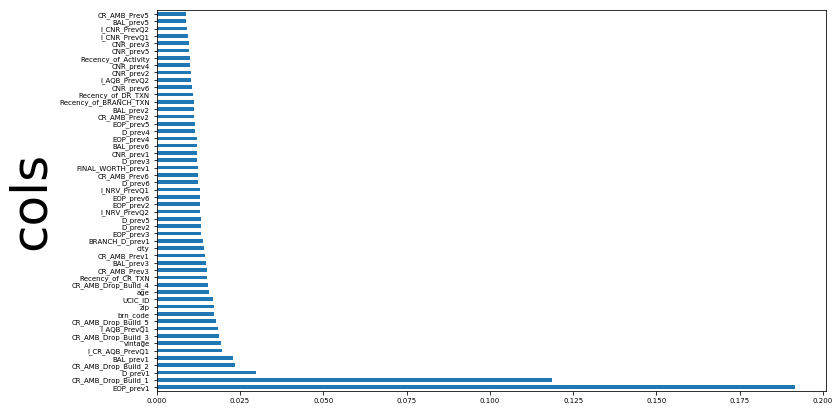

In [53]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [56]:
fi

,cols,imp
0,EOP_prev1,0.191460
1,CR_AMB_Drop_Build_1,0.118638
3,D_prev1,0.029824
6,CR_AMB_Drop_Build_2,0.023574
5,BAL_prev1,0.022912
12,I_CR_AQB_PrevQ1,0.019608
8,vintage,0.019246
9,CR_AMB_Drop_Build_3,0.018681
7,I_AQB_PrevQ1,0.018402
14,CR_AMB_Drop_Build_5,0.017629
